In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install evaluate sacrebleu
!pip install rouge_score
!pip install transformers accelerate
!pip install peft
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=2fc5bc9ac685db6bd7ea47149a0bb3f46b26db5d7345f0c4ecc0a55ea65f068a
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.9 MB/s eta 0:00:00
     ━━

In [ ]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 13.7 MB/s eta 0:00:00


In [ ]:
import os
import math
import random
import torch
import evaluate
import numpy as np
import pandas as pd
import  seaborn as sns
from matplotlib import pyplot as plt
from google.colab import files
import re
from peft import LoraConfig, get_peft_model



from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import LineByLineTextDataset
from transformers import DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer,GPT2LMHeadModel
from transformers import Trainer,TrainingArguments
from transformers import AutoTokenizer, RobertaModel
import torch
import shutil
import wandb
# from pytorch_lightning.loggers import WandbLogger
# from pytorch_lightning.callbacks import ModelCheckpoint


In [ ]:
DOWN_DATA_PATH = '/content/drive/MyDrive/Capstone/Dataset/AESLC/enron_subject_line'
LINES_DATA_PATH = 'enron_lines'
#MODEL_KEY = 'olm/olm-gpt2-dec-2022'
MODEL_KEY = 'gpt2-xl'
#MODEL_KEY = 'gpt2'
EXP_NAME = f'enron-subgen-{MODEL_KEY}'


SEED_VALUE = 15
LEARNING_RATE = 3e-5
TRAIN_BATCH_SIZE = 8
EVAL_BATCH_SIZE = 2 * TRAIN_BATCH_SIZE
N_EPOCHS = 3
LoRA = True


# SEED_VALUE = 15
# LEARNING_RATE = 5e-4
# TRAIN_BATCH_SIZE = 128
# EVAL_BATCH_SIZE = 2 * TRAIN_BATCH_SIZE
# N_EPOCHS = 50


In [ ]:
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)

In [ ]:
wandb.login()


<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [ ]:
run = wandb.init(project="Email_subject_XL")


wandb: Currently logged in as: adarshj322. Use `wandb login --relogin` to force relogin


In [ ]:
def clean_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    # Remove extra white spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
os.makedirs(LINES_DATA_PATH,exist_ok=True)
def prepare_train_dataset(down_data_path,lines_data_path,split):
    with open(os.path.join(lines_data_path,f'{split}.txt'),'w') as writer:
        filenames = os.listdir(os.path.join(down_data_path,split))
        for filename in filenames:
            with open(os.path.join(down_data_path,split,filename),'r') as reader:
                email,subject = reader.read().split('@subject')
                # email = ' '.join(email.replace('\n',' ').split()).strip()
                # subject = ' '.join(subject.replace('\n',' ').split()).strip()

                email = clean_text(email)
                subject = clean_text(subject)
                sequence = '<email>' + email + '<subject>' + subject
                writer.write(sequence + '\n')

    return


In [ ]:
def prepare_validation_dataset(down_data_path,lines_data_path,split):
    with open(os.path.join(lines_data_path,f'{split}.txt'),'w') as writer:
        filenames = os.listdir(os.path.join(down_data_path,split))
        for filename in filenames:
            with open(os.path.join(down_data_path,split,filename),'r') as reader:
                email,email_right = reader.read().split('@subject')
                subject,subject_right  = email_right.split('@ann0')
                ann0,ann0_right = subject_right.split('@ann1')
                ann1,ann2 = ann0_right.split('@ann2')


                # email = ' '.join(email.replace('\n',' ').split()).strip()
                # subject = ' '.join(subject.replace('\n',' ').split()).strip()
                # ann0 = ' '.join(ann0.replace('\n',' ').split()).strip()
                # ann1 = ' '.join(ann1.replace('\n',' ').split()).strip()
                # ann2 = ' '.join(ann2.replace('\n',' ').split()).strip()

                email = clean_text(email)
                subject = clean_text(subject)
                ann0 = clean_text(ann0)
                ann1 = clean_text(ann1)
                ann2 = clean_text(ann2)
                sequence = '<email>' + email + '<subject>' + subject + '<ann0>' + ann0 + '<ann1>' + ann1 + '<ann2>' + ann2
                writer.write(sequence + '\n')

    return

In [ ]:
prepare_train_dataset(DOWN_DATA_PATH,LINES_DATA_PATH,'train')
prepare_validation_dataset(DOWN_DATA_PATH,LINES_DATA_PATH,'dev')

prepare_validation_dataset(DOWN_DATA_PATH,LINES_DATA_PATH,'test')

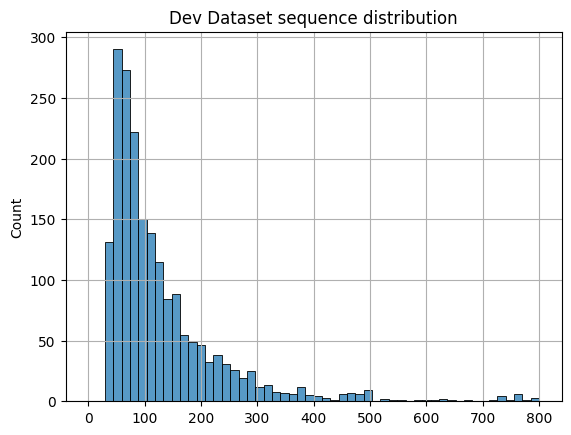

In [ ]:
with open(os.path.join(LINES_DATA_PATH,'dev.txt'),'r') as f:
    dev_lines = f.readlines()
dev_seq_lens = np.array([len(line.split()) for line in dev_lines])
sns.histplot(dev_seq_lens,binrange=(0,800))
plt.grid()
plt.title('Dev Dataset sequence distribution')
plt.show()

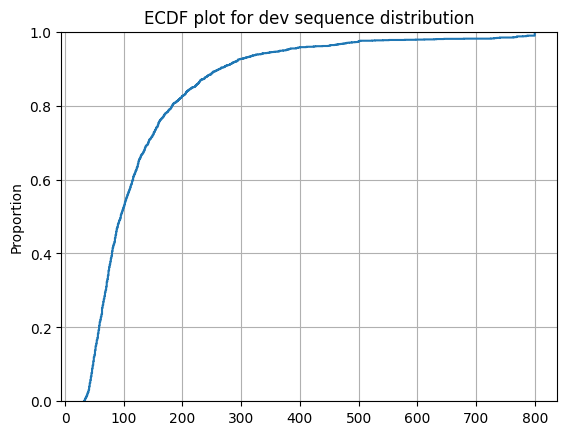

In [ ]:
sns.ecdfplot(np.clip(dev_seq_lens,a_min=0,a_max=800))
plt.grid()
plt.title('ECDF plot for dev sequence distribution')
plt.show()

In [ ]:
def load_dataset(file_path,tokenizer):
    block_size = 256 if 'train' in file_path else 512

    dataset = LineByLineTextDataset(
             tokenizer=tokenizer,
             file_path=file_path,
             block_size=block_size
    )
    return dataset

In [ ]:
def load_data_collator(tokenizer,mlm=False):
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=mlm
    )
    return data_collator

In [ ]:
tokenizer= GPT2Tokenizer.from_pretrained(MODEL_KEY)
tokenizer.add_special_tokens({'pad_token':'{PAD}'})

model = GPT2LMHeadModel.from_pretrained(MODEL_KEY)
model.resize_token_embeddings(len(tokenizer))
model.config.dropout = 0.1  # Set dropout rate
model.config.attention_dropout = 0.1  # Set attention dropout rate

#model = torch.compile(model)

type(tokenizer),type(model)

tokenizer_config.json:   0%|          | 0.00/528 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/805k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/463k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/907 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

(transformers.models.gpt2.tokenization_gpt2.GPT2Tokenizer,
 transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel)

In [ ]:
if LoRA:
    config = LoraConfig(
        r=32,
        lora_alpha=32,
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
        # tune the embedding layer and prediction head
        modules_to_save=["wte", "lm_head"]
    )
    model = get_peft_model(model, config)

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:311: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [ ]:
train_dataset=load_dataset(os.path.join(LINES_DATA_PATH,'train.txt'),tokenizer)
dev_dataset=load_dataset(os.path.join(LINES_DATA_PATH,'dev.txt'),tokenizer)
test_dataset=load_dataset(os.path.join(LINES_DATA_PATH,'test.txt'),tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:119: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [ ]:
value = train_dataset[0]

text = tokenizer.decode(value['input_ids'])

text

'<email>paul this is a purchase from dp l for 50 mwh he 11 23 at a pjm w hub index price it is not in the hourly p l and not routed in scheduling i am getting word from the counterparty that it did not happen can you shed some light so we can settle with dp l thanks<subject>790075 1 09 25 01'

In [ ]:
data_collator=load_data_collator(tokenizer)

In [ ]:
len(train_dataset),len(dev_dataset),len(test_dataset)

(14436, 1960, 1906)

In [ ]:
bleu = evaluate.load('bleu')
rouge = evaluate.load('rouge')
#meteor = evaluate.load('meteor')


def preprocess_logits_for_metrics(logits, labels):
    pred_ids = torch.argmax(logits, dim=-1)

    return pred_ids, labels



def compute_metrics(eval_preds):
    logits, labels = eval_preds
    preds = logits[0]
    preds = np.where(preds!= -100,preds, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    sequences = tokenizer.batch_decode(labels, skip_special_tokens=True)

    prompts = list()
    references = list()
    for sequence in sequences:
        try:
            prompt, ref_text = sequence.split('<subject>')
            prompt += '<subject>'
            subject, subject_right = ref_text.split('<ann0>')
            ann0, ann0_right = subject_right.split('<ann1>')
            ann1, ann2 = ann0_right.split('<ann2>')
            prompts.append(prompt)
            references.append([subject, ann0, ann1, ann2])
        except ValueError:
            continue

    tokenizer.padding_side='left'
    n_batches = math.ceil(len(prompts)*1.0 / EVAL_BATCH_SIZE)
    outputs = list()
    for i in range(n_batches):
        prompts_batch = prompts[i*EVAL_BATCH_SIZE : (i+1)*EVAL_BATCH_SIZE]
        prompts_batch_ids = tokenizer(prompts_batch,
            padding=True, truncation=True, return_tensors='pt').to(model.device)
        output_ids = model.generate(
            **prompts_batch_ids, max_new_tokens=10,
            pad_token_id=tokenizer.pad_token_id)
        outputs_batch = [seq.split('<subject>')[1] for seq in
            tokenizer.batch_decode(output_ids, skip_special_tokens=True)]
        outputs.extend(outputs_batch)
    tokenizer.padding_side='right'

    bleu_score = bleu.compute(predictions=outputs, references=references)
    rouge_score = rouge.compute(predictions=outputs, references=references)
   # meteor_score = meteor.compute(predictions=outputs, references=references)

    return {
        'BLEU': round(bleu_score['bleu'], 4) * 100,
        'R1': round(rouge_score['rouge1'], 4) * 100,
        'R2': round(rouge_score['rouge2'], 4) * 100,
        'RL': round(rouge_score['rougeL'], 4) * 100,
        'RLsum': round(rouge_score['rougeLsum'], 4) * 100,
        #'meteor': round(meteor_score['meteor'], 4) * 100,

        #'METEOR': round(meteor_score['meteor'], 4) * 100
        }


In [ ]:
# wandb_logger = WandbLogger()
# checkpoint_callback = ModelCheckpoint(dirpath='checkpoint', filename='model-{epoch:02d}', save_top_k=-1)
import os
os.environ["WANDB_LOG_MODEL"] = "checkpoint"

training_args = TrainingArguments(
          output_dir=EXP_NAME,
          overwrite_output_dir=True,
          evaluation_strategy = 'steps',
          weight_decay=0.01,
          eval_steps = 1000,
          max_steps = 10000,
          learning_rate=LEARNING_RATE,
          save_strategy = 'epoch',
          warmup_steps=5000,
          gradient_accumulation_steps=2,
          per_device_train_batch_size=TRAIN_BATCH_SIZE,
          per_device_eval_batch_size=EVAL_BATCH_SIZE,
          num_train_epochs=N_EPOCHS,
          report_to="wandb",
          fp16=True
      )

trainer = Trainer(
          model=model,
          args=training_args,
          data_collator=data_collator,
          train_dataset=train_dataset,
          eval_dataset=dev_dataset,
          preprocess_logits_for_metrics=preprocess_logits_for_metrics,
          compute_metrics=compute_metrics
  )
trainer.train()
trainer.save_model()

Step,Training Loss,Validation Loss,Bleu,R1,R2,Rl,Rlsum
1000,3.708900,3.452666,13.680000,34.430000,19.830000,33.010000,32.940000
2000,3.389800,3.340146,16.410000,39.320000,23.260000,37.140000,37.110000
3000,3.232500,3.281246,15.970000,40.500000,23.500000,38.000000,38.020000
4000,3.084300,3.263824,16.320000,40.910000,23.820000,38.580000,38.580000
5000,2.951800,3.251244,16.250000,41.580000,23.820000,38.890000,38.890000
6000,2.832400,3.264959,15.820000,40.820000,23.230000,38.380000,38.370000
7000,2.746500,3.269721,16.680000,42.020000,24.310000,39.390000,39.400000
8000,2.703400,3.281705,16.770000,41.810000,24.090000,39.250000,39.250000
9000,2.646600,3.291859,16.310000,41.690000,23.830000,39.030000,39.060000
10000,2.612700,3.292762,16.130000,41.430000,23.540000,38.780000,38.790000


wandb: Adding directory to artifact (./enron-subgen-olm/olm-gpt2-dec-2022/checkpoint-902)... Done. 4.9s
wandb: Adding directory to artifact (./enron-subgen-olm/olm-gpt2-dec-2022/checkpoint-1805)... Done. 6.9s
wandb: Adding directory to artifact (./enron-subgen-olm/olm-gpt2-dec-2022/checkpoint-2707)... Done. 6.7s
wandb: Adding directory to artifact (./enron-subgen-olm/olm-gpt2-dec-2022/checkpoint-3610)... Done. 4.8s
wandb: Adding directory to artifact (./enron-subgen-olm/olm-gpt2-dec-2022/checkpoint-4512)... Done. 4.8s
wandb: Adding directory to artifact (./enron-subgen-olm/olm-gpt2-dec-2022/checkpoint-5415)... Done. 5.8s
wandb: Adding directory to artifact (./enron-subgen-olm/olm-gpt2-dec-2022/checkpoint-6317)... Done. 4.8s
wandb: Adding directory to artifact (./enron-subgen-olm/olm-gpt2-dec-2022/checkpoint-7220)... Done. 4.8s
wandb: Adding directory to artifact (./enron-subgen-olm/olm-gpt2-dec-2022/checkpoint-8122)... Done. 5.1s
wandb: Adding directory to artifact (./enron-subgen-olm/

In [ ]:
def generateSubject(email):
    tokenizer.padding_side='left'
    input_ids = tokenizer.encode(email, return_tensors='pt', padding=True, truncation=True).to(model.device)
    output = model.generate(input_ids, max_new_tokens=10, pad_token_id=tokenizer.pad_token_id)
    tokenizer.padding_side='right'

# Decode the output to get the predicted email subject
    predicted_subject = tokenizer.decode(output[0], skip_special_tokens=True)
    return predicted_subject





In [ ]:
test_preds,test_ids,test_metrics = trainer.predict(test_dataset)
test_metrics

{'test_loss': 3.2683098316192627,
 'test_BLEU': 16.2,
 'test_R1': 42.07,
 'test_R2': 24.26,
 'test_RL': 39.18,
 'test_RLsum': 39.160000000000004,
 'test_runtime': 189.2765,
 'test_samples_per_second': 10.07,
 'test_steps_per_second': 0.634}

In [ ]:
text = "Dear Manager, I am writing to request a leave of absence for medical reasons from March 1 to March 10. Thank you for your understanding. Best, John Doe."

email = "<email>" + clean_text(text) + "<subject>"

print(email)

generateSubject(email)

<email>dear manager i am writing to request a leave of absence for medical reasons from march 1 to march 10 thank you for your understanding best john doe<subject>


TypeError: ignored

In [ ]:
artifact = wandb.Artifact('final_model', type='model')
artifact.add_dir('/content/enron-subgen-olm/olm-gpt2-dec-2022/Final_model')

run.log_artifact(artifact)
run.finish()

wandb: Adding directory to artifact (/content/enron-subgen-olm/olm-gpt2-dec-2022/Final_model)... Done. 1.2s


eval/BLEU,▁▇▆▇▇▆██▇▇
eval/R1,▁▆▇▇█▇███▇
eval/R2,▁▆▇▇▇▆██▇▇
eval/RL,▁▆▆▇▇▇███▇
eval/RLsum,▁▆▇▇▇▇███▇
eval/loss,█▄▂▁▁▁▂▂▂▂
eval/runtime,█▅▇▅▆▅▅▅▁▁
eval/samples_per_second,▁▄▂▄▃▄▄▄██
eval/steps_per_second,▁▄▂▄▃▄▄▄█▇
train/epoch,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇████


In [ ]:
from google.colab import files
files.download('/content/model_10000.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import shutil
shutil.make_archive('/content/output', 'zip', '/content/enron-subgen-olm')

'/content/output.zip'

In [ ]:
shutil.make_archive('/content/final','zip','/content/enron-subgen-olm/olm-gpt2-dec-2022/Final_model')

'/content/final.zip'

In [ ]:
shutil.copy("/content/final.zip", "/content/drive/MyDrive/Capstone/Dataset/AESLC/enron_subject_line")

'/content/drive/MyDrive/Capstone/Dataset/AESLC/enron_subject_line/final.zip'